In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

Using TensorFlow backend.


### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [2]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

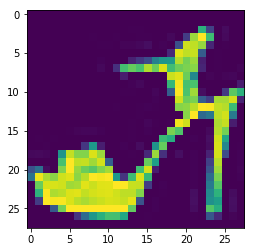

In [3]:
plt.imshow(X_train[9].reshape([28,28]))

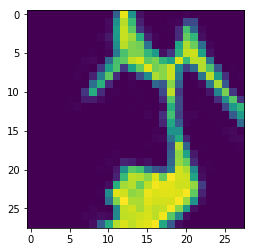

In [4]:
plt.imshow(transform.rotate(X_train[9].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [5]:
base_indices = np.random.choice(np.arange(X_train.shape[0]), size=500, replace=False)

In [6]:
base_dataset = X_train[base_indices].reshape([-1, 28,28])

In [7]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [8]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [9]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer([784]))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
n_epochs = 40

In [13]:
angle = 35

In [14]:
X, y = get_X_and_y(base_dataset, angle)
X_test_whole, y_test_whole = get_X_and_y(X_test, angle)

In [15]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=0)

y_test_predicted_whole = model.predict_classes(X_test_whole)

In [16]:
accuracy_score(y_test_whole[:, 1], model.predict_classes(X_test_whole))

0.9809

In [17]:
accuracy_score(y[:, 1], model.predict_classes(X.reshape([-1, 784])))

0.986

In [18]:
reset_weights(model)

In [ ]:
### Your code here